# NYSE Stockmarket Prediction Notebook

## Extract Transform and Loading of data
The following notebook will be used to extract Transform and load the data, this notebook also includes the initial data exploration.

The following lines of code import all the necessary libraries that are required for the success of this Data Science Project

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import math, time
from sklearn import preprocessing
import tensorflow as tf
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# This block of code reads all the CSV information for the stock exchange data until 2016 and shifts close to the end of the column
DATA_URL = 'prices-split-adjusted.csv'
df = pd.read_csv(DATA_URL)
df['Close'] = df['close']
df.drop(['close'], 1, inplace=True)
df.head()

,date,symbol,open,low,high,volume,Close
0,2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
1,2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2,2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
3,2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
4,2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [3]:
#Checks to see if there are any empty values in the data frame which there are none
df.isnull().values.any()

False

In [4]:
#Checks to see if all the stock prices are a float, which they are
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
 6   Close   851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [5]:
#Just looking to better understand the data and noting how much data is available
df.describe()

,open,low,high,volume,Close
count,851264.000000,851264.000000,851264.000000,8.512640e+05,851264.000000
mean,64.993618,64.336541,65.639748,5.415113e+06,65.011913
std,75.203893,74.459518,75.906861,1.249468e+07,75.201216
min,1.660000,1.500000,1.810000,0.000000e+00,1.590000
25%,31.270000,30.940001,31.620001,1.221500e+06,31.292776
50%,48.459999,47.970001,48.959999,2.476250e+06,48.480000
75%,75.120003,74.400002,75.849998,5.222500e+06,75.139999
max,1584.439941,1549.939941,1600.930054,8.596434e+08,1578.130005


In [6]:
# Checks the correlation of the data
df.corr()

,open,low,high,volume,Close
open,1.000000,0.999914,0.999928,-0.132526,0.999845
low,0.999914,1.000000,0.999889,-0.133087,0.999926
high,0.999928,0.999889,1.000000,-0.132168,0.999925
volume,-0.132526,-0.133087,-0.132168,1.000000,-0.132675
Close,0.999845,0.999926,0.999925,-0.132675,1.000000


The above correlation shows strong linear relationships between open, low, high and close. Volume has very little correlation.

In [7]:
#Retrieves a list of all the companies on the stock market which there are 501 and listed below
symbols = list(set(df.symbol))
print(len(symbols))
for i in symbols:
    print(i, end= " : " )

501
TXN : CBG : SLG : DOV : C : A : WFC : PKI : OMC : COO : D : NSC : EW : HSIC : NWS : VRSK : WM : TMK : CTSH : VZ : MCO : KIM : PBCT : KHC : PCAR : DRI : FFIV : WLTW : APC : STX : FISV : CSCO : MCHP : ETR : DVA : UNP : DLR : FTR : ADBE : MO : TAP : QCOM : PSX : ES : HOLX : TWX : RF : XRAY : ADI : ALXN : HRB : CFG : LLTC : SIG : SYY : DIS : HP : WY : ALB : NWSA : PLD : TSN : MUR : JNJ : PCG : SPG : APD : CB : BSX : PNC : AXP : GWW : NVDA : BMY : RL : UAA : MAR : FSLR : WAT : EQIX : IPG : MSFT : PGR : CXO : COH : HES : MAS : CINF : HPQ : SNA : BCR : EMN : NOC : UNH : WDC : HRS : ISRG : CVX : CAH : PRU : AVY : DHI : AET : COP : HBAN : PH : EXPE : INTU : MNST : FIS : HD : BAX : BXP : PVH : LEG : MTB : EFX : GOOG : CCL : LLY : V : HAS : WU : BBY : OXY : RSG : MCK : TRIP : KMX : LLL : T : NRG : KO : TXT : HIG : NI : FTI : ABBV : PNW : STT : TMO : SEE : CHK : AFL : ROP : AZO : ATVI : TDC : NDAQ : RHI : PWR : HUM : VLO : BHI : GGP : EOG : R : KMI : XRX : WYNN : O : AAPL : DISCA : PG : WMB : 

### The 'company_code' variable is the variable that needs to be changed to the relevant company symbol to perform analysis on the specific company

In [8]:
# Choosing apple as a company to look at as AAPL
company_code = 'AMZN'
df = df[df.symbol == company_code]
df.drop(['symbol'], 1, inplace=True)

In [9]:
#Brief look over the data and it starts in 2010
df.head()

,date,open,low,high,volume,Close
284,2010-01-04,136.250000,133.139999,136.610001,7599900.0,133.899994
751,2010-01-05,133.429993,131.809998,135.479996,8851900.0,134.690002
1219,2010-01-06,134.600006,131.649994,134.729996,7178800.0,132.250000
1687,2010-01-07,132.009995,128.800003,132.320007,11030200.0,130.000000
2155,2010-01-08,130.559998,129.029999,133.679993,9830500.0,133.520004


In [10]:
#Looking at the end of the data and it ends in December 2016
df.tail()

,date,open,low,high,volume,Close
848799,2016-12-23,764.549988,757.989990,766.500000,1976900.0,760.590027
849299,2016-12-27,763.400024,761.200012,774.650024,2627400.0,771.400024
849799,2016-12-28,776.250000,770.500000,780.000000,3279100.0,772.130005
850299,2016-12-29,772.400024,760.849976,773.400024,3153500.0,765.150024
850799,2016-12-30,766.469971,748.280029,767.400024,4125300.0,749.869995


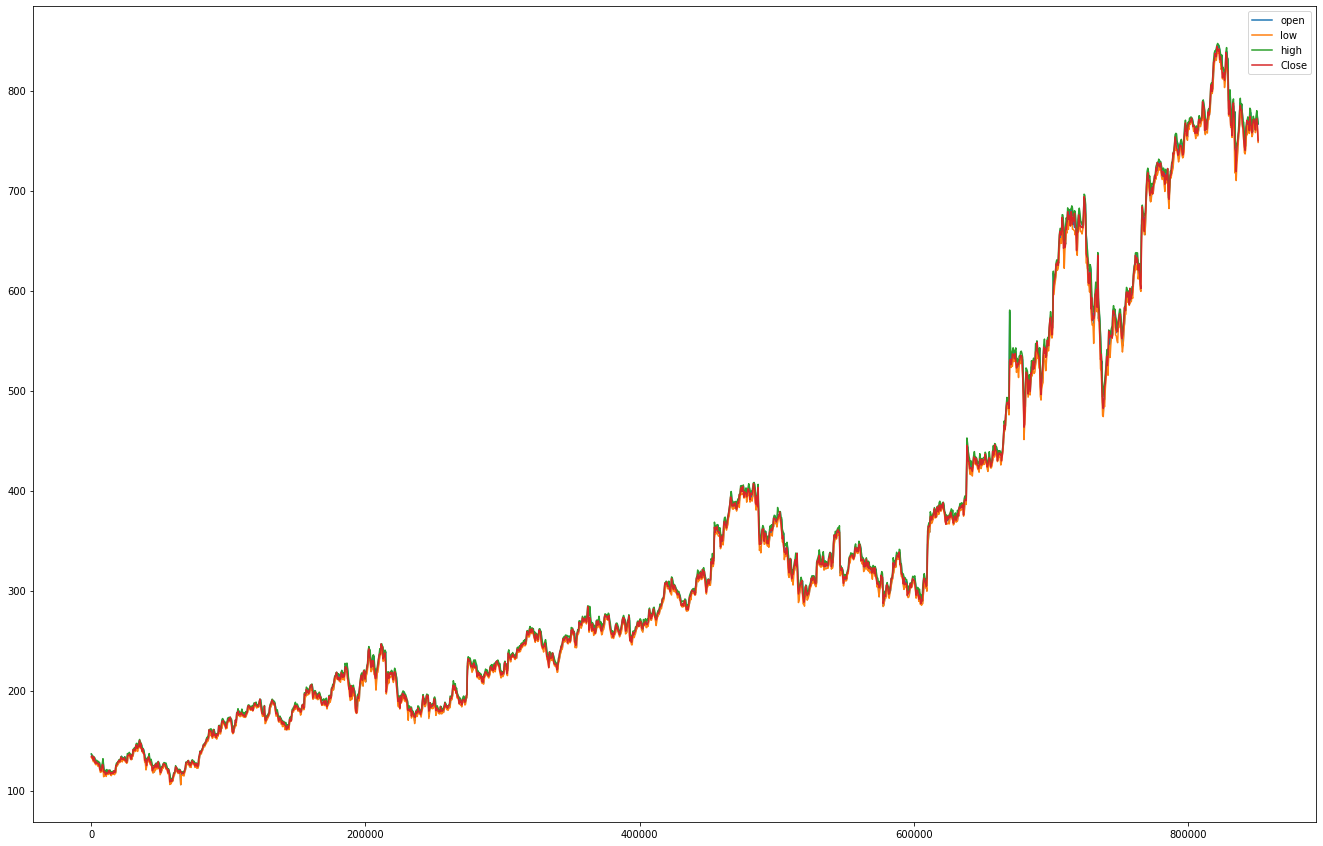

In [11]:
#Looking at the trend of the stock from start to finish and excluding volume
temp = df[['date','open','low','high', 'Close']]
temp.plot(figsize=(23,15))

## Feature Creation
##### This section of the note book is where the data is modified so that it may be interpreted by the computer in order to perform machine learning

Due to the nature of the dataset, there are no null values which means there is no need to input any missing values. However I do feel it is important to address my actions if there were missing values.
* To address the missing open stock prices I will make use of the previous days closed price as they are usually close enough and good enough to not punish the machine learning algorithm with a complete zero but still have a value that is relative to the stock.
* The same for missing closed stock prices, I will make use of the next days opening price as a value.
* Addressing low and High values, one would make use of the open and closed stock prices in a single day to see which is higher and lower. The the lowest stock price will be the lower of the two  minus a certain interval like -0.8 dollars and the same for the higher value. Again this is to not penalise the learning algorithm too much.
* Addressing missing data values, this would make use of looking at the previous date and the next date and averaging it assuming that the missing date is inbetween them. 
* Addressing missing volume values will make use of the previous and next day values and average it to an integer.
* Any other missing values will have to be manually inserted using appropriate values according to its sitation that can arise. 

The above points (excluding the last one) will make use of a function that iterates through the entire data frame in order to change every value if there were a large amount of missing values. The following code is an example of such a function that would achieve the above suggestion:

```python
#Iterates through the rows of the data and fixes missing values accordingly
for x in range(len(data)):
    #Assigns values to the index as well as each column in order to make it easier to work with the data
    index = data.iloc[x].date
    open = data['open'].iloc[x]
    close = data['Close'].iloc[x]
    volume = data['volume'].iloc[x]
    
    if "NaN" in open:
        data.at[index, 'open'] = data['Close'].iloc[x-1]  #Previous day close
    
    if "NaN" in close:
        data.at[index, 'Close'] = data['open'].iloc[x+1]  #next day open
        
    if "NaN" in volume:
        #Retrieves next day and previous day volumes and places the average
        previous_Volume = data['volume'].iloc[x-1]
        next_Volume = data['volume'].iloc[x+1]
        data.at[index, 'volume'] = (previous_Volume + next_Volume)//2 # Using integer division of average volume
        
     
```

This function is not exhaustive but it does demonstrate the manner in which the values can be placed in to help clean up the data.

#### Normalise the data
The data is normalized according to each column and plotted to see visually if this was successful

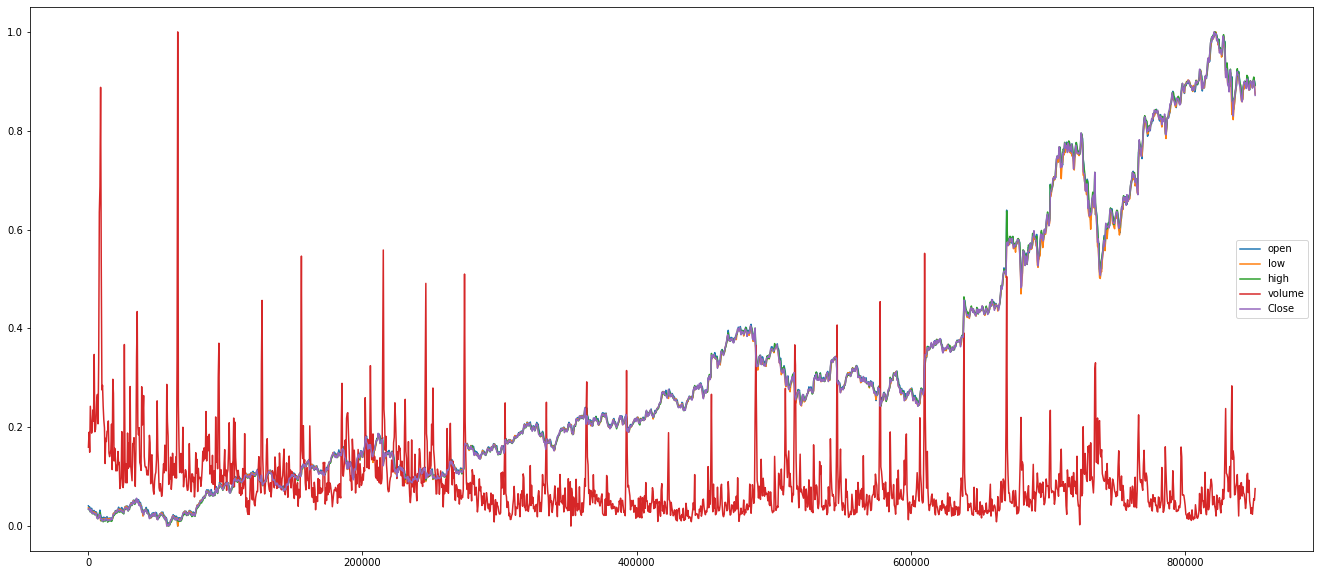

In [12]:
#Creating a normalise function and using the MinMaxScaler Library
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df.Close.values.reshape(-1,1))
    return df
df = normalize_data(df)
df.plot(figsize=(23,10))

Creating test and training set

In [13]:
#Creates a function to create the test and training data with the stock df and sequence length as parameters
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # The features are the columns excluding date
    data = stock.to_numpy() #changes the code over to a matrix
    sequence_length = seq_len + 1 # adjusts the index
    result = []  # Empty list to store the full data
    
    for index in range(len(data) - sequence_length): # Checks to see how far we are from the most recent date
        result.append(data[index: index + sequence_length]) # Appending the data to result
    
    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split for test and training data
    train = result[:int(row), :] # Creates a train list with all the training data in it including the x and y values
    
    x_train = train[:, :-1] #Extracts the training x and y values from the train list
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] #Extracts the test data from result list
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))  #Transfroms the shape of the data to be ready for
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]   #Returns the test and training data from the function to be used in the LSTM



### Build the model

In [14]:
#Creates a new data frame containing just the features and excludes the date
new_df = df[['open', 'low', 'high', 'volume', 'Close']]
new_df.head()
#Quick overview of the data going to be used in the model

,open,low,high,volume,Close
284,0.040981,0.037207,0.034406,0.159653,0.034373
751,0.037169,0.035397,0.032870,0.189868,0.035447
1219,0.038751,0.035180,0.031851,0.149491,0.032130
1687,0.035250,0.031301,0.028576,0.242437,0.029072
2155,0.033290,0.031614,0.030424,0.213485,0.033857


In [15]:
new_df.tail()

,open,low,high,volume,Close
848799,0.890195,0.887575,0.890328,0.023952,0.886143
849299,0.888641,0.891943,0.901402,0.039651,0.900836
849799,0.906009,0.904600,0.908672,0.055378,0.901828
850299,0.900806,0.891467,0.899704,0.052347,0.892341
850799,0.892791,0.874360,0.891551,0.075800,0.871573


In [16]:
new_df.shape

(1762, 5)

## Building the LSTM Model
This model is adjusted and tweaked according to the performance of the model

The compiled model makes use of the RMSprop optimiser as this [paper](http://www.ijitee.org/wp-content/uploads/papers/v9i3/C8026019320.pdf) has shown better accuracy with its use.
Mean Squared error is used to find the the line of best fit to the predicted points and is most appropriate.

In [17]:
def build_model(layers):
    d = 0.2 #drop rate of 20% This value is adjusted according to the fit of the data since the memory use is not expensive
    LSTM_input = 50
    model = Sequential() #Creates a sequential model stored in the variable 'model'
    
    #Adds LSTMs to the sequential model and dropsout 20% of the neurons after each iteration
    model.add(LSTM(LSTM_input, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(Dense(64))  
    
    model.add(LSTM(LSTM_input, input_shape=(layers[1], layers[0]), return_sequences=False))
    
    model.add(Dropout(d))
        
    # ACitvation function 'Recitifed linear unit' appropriate due to the non-linear nature of the stock market.
    model.add(Dense(1,kernel_initializer="uniform",activation='relu'))        
    
    opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
    )        
    start = time.time()
    model.compile(loss='mse',optimizer= opt, metrics=['accuracy'])
    return model

Retrieving data to train and considering a window period of x days

In [18]:
window = 15 #x is the values of day intervals to be changed according to the performance of the model
X_train, y_train, X_test, y_test = load_data(new_df, window)
print (X_train[0], y_train[0])

[[0.04098073 0.0372074  0.03440591 0.15965316 0.03437308]
 [0.03716919 0.03539738 0.03287041 0.18986792 0.03544683]
 [0.03875058 0.03517963 0.03185128 0.14949067 0.03213048]
 [0.03524991 0.03130104 0.02857648 0.24243726 0.02907237]
 [0.03329008 0.03161404 0.03042449 0.21348466 0.03385661]
 [0.03607439 0.03185902 0.02922872 0.18811826 0.02949371]
 [0.03116807 0.02823898 0.02517937 0.19576607 0.0254706 ]
 [0.02969481 0.02715024 0.0250299  0.23502837 0.02786273]
 [0.0313708  0.02803484 0.02594032 0.21214286 0.0254706 ]
 [0.03142486 0.02893304 0.02494835 0.34732737 0.02518518]
 [0.02754575 0.02521775 0.02270627 0.19085014 0.02582399]
 [0.02865407 0.02623843 0.02433688 0.1952448  0.02333673]
 [0.02882978 0.02612956 0.02291009 0.21686573 0.02447843]
 [0.02658611 0.02035928 0.02225785 0.25543781 0.0174244 ]
 [0.02185548 0.01676647 0.01493369 0.26641842 0.01590214]] 0.01477404313473965


In [19]:
model = build_model([5,window,1])

In [20]:
#Setting the epochs and batch size. This is according to model performance as well as computational cost. These values are
# variable and can be changed to adjust the performance of the model.
epoch = 10
batch = 32

In [21]:
model.fit(X_train,y_train,batch_size=batch,epochs=epoch,validation_split=0.1,verbose=1)

Train on 1257 samples, validate on 140 samples
Epoch 1/10
1257/1257 [==============================] - 1s 1ms/step - loss: 0.0043 - accuracy: 7.9554e-04 - val_loss: 9.7720e-04 - val_accuracy: 0.0000e+00
Epoch 2/10
1257/1257 [==============================] - 0s 380us/step - loss: 0.0013 - accuracy: 7.9554e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 3/10
1257/1257 [==============================] - 0s 386us/step - loss: 0.0010 - accuracy: 7.9554e-04 - val_loss: 0.0160 - val_accuracy: 0.0000e+00
Epoch 4/10
1257/1257 [==============================] - 0s 374us/step - loss: 0.0011 - accuracy: 7.9554e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 5/10
1257/1257 [==============================] - 0s 363us/step - loss: 9.2484e-04 - accuracy: 7.9554e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 6/10
1257/1257 [==============================] - 0s 361us/step - loss: 8.4362e-04 - accuracy: 7.9554e-04 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 7/10
1257/125

In [22]:

diff=[]
ratio=[]
predict = model.predict(X_test)
print (predict.shape)
# for each data index in test data
for i in range(len(y_test)):
    temp = predict[i][0]
    ratio.append((y_test[i]/temp)-1)
    diff.append(abs(y_test[i]- temp))

(349, 1)


In [23]:
#This block of code imports the data again and denormalises the data to retrieve the actual values and not the normalised values
df = pd.read_csv(DATA_URL)
df["Close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == company_code] #Looking only at the company in question
df.drop(['symbol'],1,inplace=True)

# Denormalised function
def denormalize(df, normalized_value): 
    df = df['Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

Prediction = denormalize(df, predict)
Test = denormalize(df, y_test)

In [24]:
# Checking the model score using the Mean sequared error and root mean squared error method
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


trainscore, testscore = model_score(model, X_train, y_train, X_test, y_test)
train_score = str(round(trainscore, 5)) + " - Train MSE"
test_score = str(round(testscore, 5)) + " - Test MSE"

Train Score: 0.00054 MSE (0.02 RMSE)
Test Score: 0.05298 MSE (0.23 RMSE)


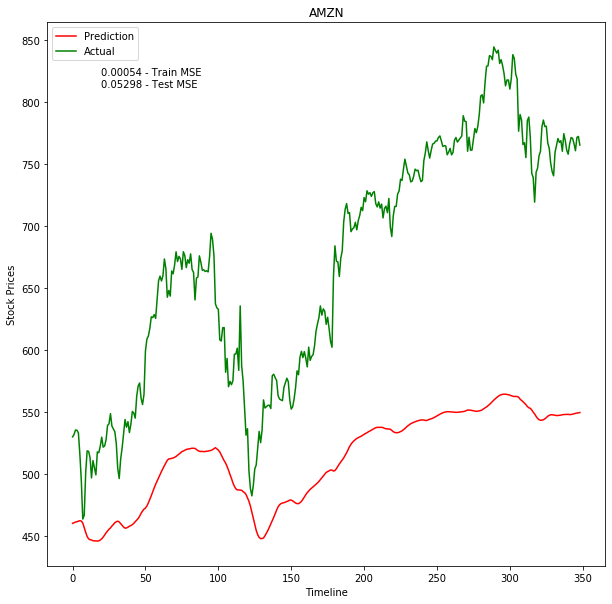

In [25]:
# Plotting the predicted and actual values using pyplot

plt.figure(figsize=(10,10))
plt.plot(Prediction,color='Red', label='Prediction')
plt.plot(Test,color='Green', label='Actual')
Train_MSE = mpatches.Patch(color='blue', label=train_score)
Test_MSE = mpatches.Patch(color='yellow', label=test_score)
# Add title, axis names and Legend

extraString = train_score + '\n' + test_score
plt.figtext(0.2, 0.79, extraString)

            
plt.title(company_code)
plt.xlabel('Timeline')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

## Final Comments

The graph is definitely able to interpret the trends and gives an excellent RMSE and MSE score. This model can be used to predict the trends of stock prices of any stock on the NYSE.